<a href="https://colab.research.google.com/github/callmesidhu/ML-Zudio-inventory-predition/blob/main/zudio_inventory_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# 1. ADVANCED SETUP & LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import xgboost as xgb  # <--- NEW: Extreme Gradient Boosting
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
from google.colab import files
import io

# Load dataset
try:
    df = pd.read_csv("Zudio_sales_data.csv")
    print("File 'Zudio_sales_data.csv' loaded successfully.")
except FileNotFoundError:
    print("Zudio_sales_data.csv not found. Please upload the file.")
    uploaded = files.upload()
    if "Zudio_sales_data.csv" in uploaded:
        df = pd.read_csv(io.BytesIO(uploaded["Zudio_sales_data.csv"]))
        print("File uploaded and loaded successfully.")
    else:
        print("The uploaded file was not named 'Zudio_sales_data.csv'. Please upload the correct file or rename it.")
        raise FileNotFoundError("Required file 'Zudio_sales_data.csv' not found after upload attempt.")

# Preview
df.head()

File 'Zudio_sales_data.csv' loaded successfully.


,Store,Country,State,City,Category,Clothing Type,Store Number,Postal Code,Store Type,Store Open Date,...,Security Features,Order ID,Order Date,Month,Customer ID,Customer Name,Product ID,Price,Quantity,Sales Profit
0,Zudio,India,Karnataka,Jalna,Women,Dresses,30,411084,Owned,2022-06-04,...,Alarm,88240,2024-11-06,November,233084,Michele Ochoa,354,1958,5,3916.0
1,Zudio,India,Gujarat,Patna,Kids,Skirts,48,404562,Owned,2020-12-19,...,Alarm,78145,2024-06-17,June,926472,Daniel Jimenez,741,2078,1,831.2
2,Zudio,India,Uttar Pradesh,Kolkata,Men,Hoodies,97,437773,Rented,2023-09-04,...,CCTV,33363,2024-08-17,August,853255,Steven Davis,607,1445,2,1156.0
3,Zudio,India,West Bengal,Kolkata,Women,Dresses,93,431725,Owned,2024-04-11,...,CCTV,46682,2024-03-27,March,106146,Derek Orozco,991,2469,6,5925.6
4,Zudio,India,West Bengal,Guwahati,Men,Dresses,51,415370,Owned,2022-05-29,...,"CCTV, Alarm",58242,2024-04-08,April,264070,Victor Arnold,479,1105,6,2652.0


In [ ]:
# ==========================================
# 2. ADVANCED FEATURE ENGINEERING
# ==========================================
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [ ]:
# A. Holiday Feature (Manual List for Major Indian Retail Events)
# Zudio sales spike during these times. We flag them.
holidays = pd.to_datetime([
    '2024-01-26', '2024-08-15', '2024-10-02', # National Holidays
    '2024-11-01', '2024-11-12', # Diwali Season
    '2024-12-25', '2025-01-01'  # Christmas / New Year
])

df['Is_Holiday'] = df['Order Date'].isin(holidays).astype(int)

In [ ]:
# B. Location-Wise Aggregation
# Grouping by Date + City + Category
daily_data = df.groupby(['Order Date', 'City', 'Category', 'Is_Holiday'])[['Quantity', 'Price']].sum().reset_index()
daily_data = daily_data.sort_values(by=['City', 'Category', 'Order Date'])

In [ ]:
# C. Advanced Lags (Short, Medium, Long Term Memory)
# Lag 1 = Yesterday
# Lag 7 = Last Week
# Lag 30 = Last Month (New!)
daily_data['Lag_1'] = daily_data.groupby(['City', 'Category'])['Quantity'].shift(1)
daily_data['Lag_7'] = daily_data.groupby(['City', 'Category'])['Quantity'].shift(7)
daily_data['Lag_30'] = daily_data.groupby(['City', 'Category'])['Quantity'].shift(30)

In [ ]:
# D. Rolling Statistical Features
# Rolling Mean (Trend) & Rolling Std Dev (Volatility)
daily_data['Rolling_Mean_7'] = daily_data.groupby(['City', 'Category'])['Quantity'].transform(lambda x: x.rolling(7).mean())
daily_data['Volatility_7'] = daily_data.groupby(['City', 'Category'])['Quantity'].transform(lambda x: x.rolling(7).std())

In [ ]:
# Drop NaNs
daily_data.dropna(inplace=True)

In [ ]:
# E. Encoding
le_cat = LabelEncoder()
daily_data['Category_Code'] = le_cat.fit_transform(daily_data['Category'])
le_city = LabelEncoder()
daily_data['City_Code'] = le_city.fit_transform(daily_data['City'])

In [ ]:
# ==========================================
# 3. ENSEMBLE MODEL TRAINING (THE "ADVANCED" PART)
# ==========================================
features = ['Category_Code', 'City_Code', 'Price', 'Is_Holiday',
            'Lag_1', 'Lag_7', 'Lag_30', 'Rolling_Mean_7', 'Volatility_7']
target = 'Quantity'

X = daily_data[features]
y = daily_data[target]

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# --- Model 1: Random Forest (Good for non-linear patterns) ---
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [ ]:
# --- Model 2: XGBoost (The Industry Standard) ---
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

In [ ]:
# --- The Ensemble: Voting Regressor ---
# We average the predictions of both models. This reduces overfitting.
voting_model = VotingRegressor(estimators=[('rf', rf), ('xgb', xg_reg)])
voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=10,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
import pandas as pd

# Load the generated CSV file
forecast_df = pd.read_csv('Zudio_Advanced_Forecast.csv')

# Display the first 5 rows of the forecast data
print("Preview of Zudio_Advanced_Forecast.csv:")
display(forecast_df.head())

Preview of Zudio_Advanced_Forecast.csv:


,Category_Code,City_Code,Price,Is_Holiday,Lag_1,Lag_7,Lag_30,Rolling_Mean_7,Volatility_7,Actual,Forecast,Category,City,Date
0,1,33,1351,0,8.0,2.0,5.0,4.000000,2.645751,2,3.749469,Men,Rajkot,2024-07-08
1,1,33,2863,0,2.0,7.0,3.0,3.714286,2.360387,5,3.481931,Men,Rajkot,2024-07-22
2,1,33,3422,0,5.0,4.0,1.0,4.428571,3.101459,9,8.801393,Men,Rajkot,2024-07-23
3,1,33,1115,0,9.0,2.0,3.0,5.000000,2.943920,6,3.497928,Men,Rajkot,2024-08-01
4,1,33,976,0,6.0,4.0,4.0,4.714286,3.147183,2,3.331154,Men,Rajkot,2024-08-03


In [ ]:
# You can also check the data types and overall structure
print("\nInfo about Zudio_Advanced_Forecast.csv:")
forecast_df.info()


Info about Zudio_Advanced_Forecast.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category_Code   681 non-null    int64  
 1   City_Code       681 non-null    int64  
 2   Price           681 non-null    int64  
 3   Is_Holiday      681 non-null    int64  
 4   Lag_1           681 non-null    float64
 5   Lag_7           681 non-null    float64
 6   Lag_30          681 non-null    float64
 7   Rolling_Mean_7  681 non-null    float64
 8   Volatility_7    681 non-null    float64
 9   Actual          681 non-null    int64  
 10  Forecast        681 non-null    float64
 11  Category        681 non-null    object 
 12  City            681 non-null    object 
 13  Date            681 non-null    object 
dtypes: float64(6), int64(5), object(3)
memory usage: 74.6+ KB


In [ ]:
# Predict
final_preds = voting_model.predict(X_test)

In [ ]:
# ==========================================
# 4. BUSINESS-LEVEL EVALUATION
# ==========================================
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

In [ ]:
# MAPE (Mean Absolute Percentage Error) - Managers understand this!
mape = np.mean(np.abs((y_test - final_preds) / y_test)) * 100

print("\n--- 🏆 ADVANCED MODEL PERFORMANCE ---")
print(f"MAE (Avg Error in Units): {mae:.2f}")
print(f"MAPE (Error Percentage):  {mape:.2f}%")
print(f"R2 Score (Accuracy):      {r2:.2f}")


--- 🏆 ADVANCED MODEL PERFORMANCE ---
MAE (Avg Error in Units): 1.89
MAPE (Error Percentage):  72.51%
R2 Score (Accuracy):      0.40


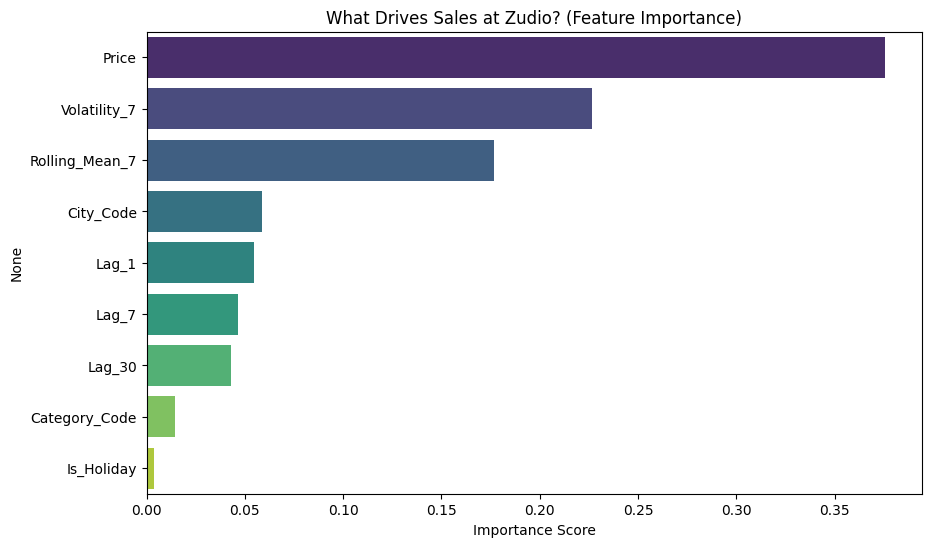

In [ ]:
# ==========================================
# 5. FEATURE IMPORTANCE (Explainability)
# ==========================================
# We use the Random Forest part of the ensemble to explain "Why?"
importances = rf.fit(X_train, y_train).feature_importances_
feature_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.title("What Drives Sales at Zudio? (Feature Importance)")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
# ==========================================
# 6. EXPORT FINAL DATA
# ==========================================
results = X_test.copy()
results['Actual'] = y_test
results['Forecast'] = final_preds
results['Category'] = le_cat.inverse_transform(results['Category_Code'])
results['City'] = le_city.inverse_transform(results['City_Code'])
results['Date'] = daily_data.loc[results.index, 'Order Date']

# Add Holiday Flag to output for Power BI coloring
results['Is_Holiday'] = daily_data.loc[results.index, 'Is_Holiday']

results.to_csv("Zudio_Advanced_Forecast.csv", index=False)
print("\n✅ Advanced Analysis Complete. File 'Zudio_Advanced_Forecast.csv' is ready.")


✅ Advanced Analysis Complete. File 'Zudio_Advanced_Forecast.csv' is ready.
